In [ ]:
# big shout out to these folks
# https://github.com/alsnhll/SEIR_COVID19/blob/master/SEIR_COVID19.ipynb

In [4]:
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

In [6]:
import seaborn as sns

In [7]:
timeseries_df = pd.read_csv('../data/timeseries.csv')

In [8]:
beds = pd.read_csv('../data/beds.csv')

In [9]:
beds.head()

,state,country,bedspermille
0,AL,USA,3.1
1,AK,USA,2.2
2,AZ,USA,1.9
3,AR,USA,3.2
4,CA,USA,1.8


In [17]:
us_df = timeseries_df.loc[(timeseries_df['country'] == 'USA'), :]

In [19]:
#us_df.loc[(timeseries_df['state'] == 'TX') & (timeseries_df['cases'] > 0), :]

In [20]:
us_df['datetime'] = pd.to_datetime(us_df['date'])

# us_df.set_index(['datetime', 'state'], inplace=True)

/Users/trae/.virtualenvs/redzone/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
print(us_df.shape)
us_last_df = us_df.sort_values('datetime').groupby(['state', 'county']).last().reset_index()
print(us_last_df.shape)

(7518, 16)
(1292, 16)


In [22]:
us_last_df.head()

,state,county,city,country,population,lat,long,url,cases,deaths,recovered,active,tested,growthFactor,date,datetime
0,AK,Anchorage Economic Region,NaN,USA,294356.0,61.108910,-149.362950,http://dhss.alaska.gov/dph/Epi/id/Pages/COVID-...,17.0,NaN,NaN,17.0,NaN,NaN,2020-03-23,2020-03-23
1,AK,Gulf Coast Economic Region,NaN,USA,80866.0,59.491968,-148.903015,http://dhss.alaska.gov/dph/Epi/id/Pages/COVID-...,3.0,NaN,NaN,3.0,NaN,NaN,2020-03-23,2020-03-23
2,AK,Interior Economic Region,NaN,USA,109847.0,65.204163,-151.024977,http://dhss.alaska.gov/dph/Epi/id/Pages/COVID-...,7.0,NaN,NaN,7.0,NaN,NaN,2020-03-23,2020-03-23
3,AK,Mat-Su Economic Region,NaN,USA,107610.0,62.337477,-149.715168,http://dhss.alaska.gov/dph/Epi/id/Pages/COVID-...,2.0,NaN,NaN,2.0,NaN,NaN,2020-03-23,2020-03-23
4,AK,Southeast Economic Region,NaN,USA,72373.0,57.598405,-136.934731,http://dhss.alaska.gov/dph/Epi/id/Pages/COVID-...,7.0,NaN,NaN,7.0,NaN,NaN,2020-03-23,2020-03-23


In [23]:
us_last_df.loc[:, ['cases', 'deaths', 'recovered', 'active']] = us_last_df.loc[:, ['cases', 'deaths', 'recovered', 'active']].fillna(0)

In [24]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    t = None
    
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [26]:
def sir(start_date, end_date, pop_dict, beta, gamma):
    # Initial conditions vector
    # print(pop_dict['total'], pop_dict['infected'], pop_dict['recovered'], pop_dict['deaths'])
    
    susceptible = pop_dict['total'] - pop_dict['infected'] - pop_dict['recovered'] - pop_dict['deaths']
    
    y0 = susceptible, pop_dict['infected'], pop_dict['recovered']
    
    delta = end_date - start_date
        
    t = np.linspace(0, delta.days, delta.days )
    
    # print(y0, t, beta, gamma)
    ret = odeint(deriv, y0, t, args=(pop_dict['total'], beta,gamma,))
    
    return ret.T

In [36]:
# https://github.com/alsnhll/SEIR_COVID19/blob/master/SEIR_COVID19.ipynb

#Defining the differential equations

#Don't track S because all variables must add up to 1 
#include blank first entry in vector for beta, gamma, p so that indices align in equations and code. 
#In the future could include recovery or infection from the exposed class (asymptomatics)

def deriv_seird(y,t,N,b,a,g,p,u): 
    dy=[0,0,0,0,0,0]
    S=N-sum(y);
    dy[0]=np.dot(b[1:3],y[1:3])*S-a*y[0] # E
    dy[1]= a*y[0]-(g[1]+p[1])*y[1] #I1
    dy[2]= p[1]*y[1] -(g[2]+p[2])*y[2] #I2
    dy[3]= p[2]*y[2] -(g[3]+u)*y[3] #I3
    dy[4]= np.dot(g[1:3],y[1:3]) #R
    dy[5]=u*y[3] #D

    return dy

In [37]:
def seird(start_date, end_date, pop_dict, beta, alpha, gamma, rho, mu):
    # Initial conditions vector
    # print(pop_dict['total'], pop_dict['infected'], pop_dict['recovered'], pop_dict['deaths'])
    
    susceptible = pop_dict['total'] - pop_dict['infected'] - pop_dict['recovered'] - pop_dict['deaths']
    
    y0 = susceptible, pop_dict['infected'], pop_dict['recovered'], 0,0,0
    
    delta = end_date - start_date
    
    print(delta)
    
    t = np.linspace(0, delta.days, delta.days )
    
    # print(y0, t, beta, gamma)
    ret = odeint(deriv_seird, y0, t, args=(pop_dict['total'], beta,  alpha, gamma, rho, mu))
    
    return ret.T

In [76]:
# Define parameters based on clinical observations

#I will add sources soon
# https://github.com/midas-network/COVID-19/tree/master/parameter_estimates/2019_novel_coronavirus



b=np.zeros(4) #beta
g=np.zeros(4) #gamma
p=np.zeros(3)

a=1/IncubPeriod

u=(1/TimeICUDeath)*(CFR/FracCritical)
g[3]=(1/TimeICUDeath)-u

p[2]=(1/DurHosp)*(FracCritical/(FracCritical+FracSevere))
g[2]=(1/DurHosp)-p[2]

g[1]=(1/DurMildInf)*FracMild
p[1]=(1/DurMildInf)-g[1]

#b=2e-4*np.ones(4) # all stages transmit equally
b=2.5e-4*np.array([0,1,0,0]) # hospitalized cases don't transmit

tmax=120
tvec=np.arange(0,tmax,0.1)
ic=np.zeros(6)
ic[0]=1

In [77]:
end_date = datetime(2020, 12, 31)
beta = 0.2
gamma = 1./10

def run_row(row):

    pop_dict = {
        'total': row['population'],
        'infected': row['active'],
        'recovered': row['recovered'],
        'deaths': row['deaths']
    }
    
    # print(row)
    
    N = pop_dict['total']
    
    #Calculate basic reproductive ratio
    R0=N*((b[1]/(p[1]+g[1]))+(p[1]/(p[1]+g[1]))*(b[2]/(p[2]+g[2])+ (p[2]/(p[2]+g[2]))*(b[3]/(u+g[3]))))
    print("R0 = {0:4.1f}".format(R0))
    
    #(S, I, R) = sir(row['datetime'], end_date, pop_dict, beta, gamma)
    (S, E, Ia, Ib, Ic, R) = seird(row['datetime'], end_date, pop_dict, b, a, g, p, u)
    
    dates = pd.date_range(start=row['datetime'], end=(end_date - timedelta(1)), freq='D').to_list()
    
    state = [row['state']] * len(S)
    county = [row['county']] * len(S)
    
    sir_df = pd.DataFrame(zip(state, county, S, E, Ia, Ib, Ic, R), columns=['state', 'county', 'susceptible', 'exposed',
                                                                            'infectedA', 'infectedB', 'infectedC',
                                                                            'recovered'], index=dates)
    
    return sir_df

In [78]:
df_list = us_last_df.loc[[0, 5], :].apply(run_row, axis=1)

R0 = 735.9
283 days 00:00:00
R0 = 735.9
283 days 00:00:00
R0 = 545.1
283 days 00:00:00


In [79]:
len(df_list)

2

In [80]:
df_list[0].head()

,state,county,susceptible,exposed,infectedA,infectedB,infectedC,recovered
2020-03-23,AK,Anchorage Economic Region,294339.000000,17.000000,0.000000,0.000000,0.000000,0.000000
2020-03-24,AK,Anchorage Economic Region,240813.603346,50857.326668,520.659172,3.946588,2160.383652,0.058143
2020-03-25,AK,Anchorage Economic Region,197022.735725,87597.732493,1828.498233,27.619052,7878.475127,0.836215
2020-03-26,AK,Anchorage Economic Region,161198.195405,113266.184703,3614.942623,81.595229,16191.031345,3.809505
2020-03-27,AK,Anchorage Economic Region,131893.845975,130296.165364,5650.420717,169.376690,26334.908933,10.843557


           state                     county    susceptible        exposed  \
2020-03-23    AK  Anchorage Economic Region  294339.000000      17.000000   
2020-03-24    AK  Anchorage Economic Region  240813.603346   50857.326668   
2020-03-25    AK  Anchorage Economic Region  197022.735725   87597.732493   
2020-03-26    AK  Anchorage Economic Region  161198.195405  113266.184703   
2020-03-27    AK  Anchorage Economic Region  131893.845975  130296.165364   

              infectedA   infectedB     infectedC  recovered  
2020-03-23     0.000000    0.000000      0.000000   0.000000  
2020-03-24   520.659172    3.946588   2160.383652   0.058143  
2020-03-25  1828.498233   27.619052   7878.475127   0.836215  
2020-03-26  3614.942623   81.595229  16191.031345   3.809505  
2020-03-27  5650.420717  169.376690  26334.908933  10.843557  


<Figure size 1080x576 with 0 Axes>

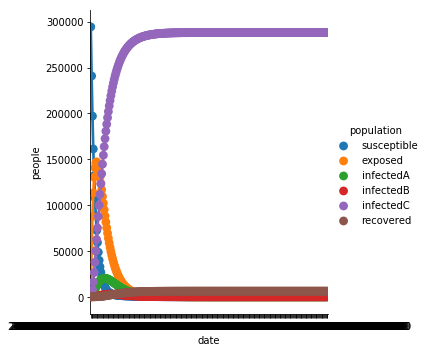

In [81]:
def plot_sir(df):
    print(df.head())
    
    df.index.name = 'date'
    df.drop(['state', 'county'], axis=1, inplace=True)

    df = df.reset_index().melt('date', var_name='population', value_name='people')
        
    sir_plot = sns.factorplot(x='date', y='people', hue='population', data=df)
    
    return sir_plot

plt.figure(figsize=(15,8))

plot_sir(df_list[0])

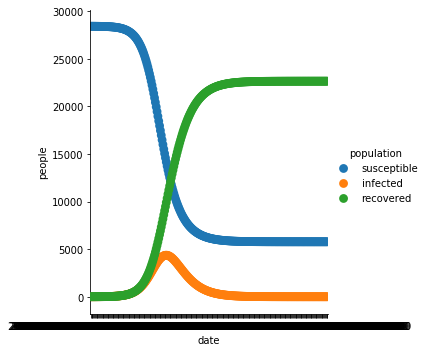

In [81]:
plot_sir(df_list[183])